## 분석하면서 생각한 핵심포인트
  - train[family_size] > 7 인 이상치 제거
  - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성
  (단, 같은 사용자가 여러번 카드를 발급할 수 있다는 가정 하에 begin_month는 개인정보에서 제외함)
  - 개인의 특성이 될 만한 파생변수 추가 
  - Catboost 모델 사용

### Google Colab mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 패키지 설치

In [ ]:
!pip install catboost
# !pip install category_encoders

## 라이브러리 구성

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
# from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/data_folder/카드 데이터/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

## 데이터 전처리

### 1. 결측치 처리

In [ ]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

### 2. 이상치 처리
-  train['family_size'] > 7 인 데이터 제거

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수
 - numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
 - category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음
 - ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    df['ability2'] = df['income_total'] / df['Age']
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

    df['ID3'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['family_size'].astype(str) + '_' +\
    df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

    df['ID4'] = \
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str)


    df['ID2'] = \
    df['income_total'].astype(str) + '_' + df['DAYS_BIRTH'].astype(str)

    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_' + df['income_total_befofeEMP_ratio'].astype(str) + '_' +\
    # df['Age'].astype(str)+ '_' + df['EMPLOYED'].astype(str) + '_' +\
    # df['ability'].astype(str)+ '_' + df['income_mean'].astype(str) #age는 빼는게 좋아보임.

    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)  0.661

    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_'+ df['income_mean'].astype(str) 0.662

    # df['ID5'] = \
    # df['income_total_befofeEMP_ratio'].astype(str) + '_'+ df['EMPLOYED'].astype(str) 0.661

    # df['ID5'] = \
    # df['income_total_befofeEMP_ratio'].astype(str) + '_'+ df['ability'].astype(str) 0.662


    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)  + '_' +\
    # df['income_mean'].astype(str)  0.661

    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)  + '_' +\
    # df['income_total_befofeEMP_ratio'].astype(str)  0.661

    # df['ID5'] = \
    # df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)  + '_' +\
    # df['income_mean'].astype(str) + '_'+ df['EMPLOYED'].astype(str)

    # df['ID5'] = \
    # df['ability'].astype(str) + '_' + df['ability2'].astype(str)

    # df['ID6'] = \
    # df['child_num'] + df['income_total']+\
    # df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'] +\
    # df['work_phone'] + df['phone'] +\
    # df['email'] + df['family_size'] +\
    # df['begin_month'] + df['before_EMPLOYED'] +\
    # df['income_total_befofeEMP_ratio'] + df['before_EMPLOYED_m'] +\
    # df['before_EMPLOYED_w'] + df['Age'] +\
    # df['DAYS_BIRTH_m'] + df['DAYS_BIRTH_w'] +\
    # df['EMPLOYED'] + df['ability']

    # 기존 ID5에서 최소한의 columns으로 새로운 ID5 생성
    df['ID5'] = \
    df['before_EMPLOYED'].astype(str) + '_'+ df['ability'].astype(str)

In [ ]:
# ID5, begin_month를 제외한 나머지 columns 모두 제거
cols = ['phone','gender','work_phone','car','child_num','email','reality',
        'before_EMPLOYED','income_total_befofeEMP_ratio',
        'before_EMPLOYED_m','before_EMPLOYED_w','Age','DAYS_BIRTH_m',
        'DAYS_BIRTH_w','EMPLOYED','DAYS_EMPLOYED_m','DAYS_EMPLOYED_w',
        'ability','income_mean','income_total','income_type','edu_type','family_type',
        'house_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','family_size','ability2',
        'ID','ID2','ID3','ID4']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26451 non-null  object 
 1   car                           26451 non-null  object 
 2   reality                       26451 non-null  object 
 3   child_num                     26451 non-null  int64  
 4   income_total                  26451 non-null  float64
 5   income_type                   26451 non-null  object 
 6   edu_type                      26451 non-null  object 
 7   family_type                   26451 non-null  object 
 8   house_type                    26451 non-null  object 
 9   DAYS_BIRTH                    26451 non-null  int64  
 10  DAYS_EMPLOYED                 26451 non-null  int64  
 11  work_phone                    26451 non-null  int64  
 12  phone                         26451 non-null  int64  
 13  e

In [ ]:
len(train["ID5"].value_counts().index.tolist())

8698

In [ ]:
len(train["ID"].value_counts().index.tolist())

8756

### 5. 파생변수와 다중공선을 보이는 컬럼 삭제

In [ ]:
# 0   income_total   26451 non-null  float64
#  1   income_type    26451 non-null  object 
#  2   edu_type       26451 non-null  object 
#  3   family_type    26451 non-null  object 
#  4   house_type     26451 non-null  object 
#  5   DAYS_BIRTH     26451 non-null  int64  
#  6   DAYS_EMPLOYED  26451 non-null  int64  
#  7   occyp_type     26451 non-null  object 
#  8   family_size    26451 non-null  float64
#  9   begin_month    26451 non-null  float64
#  10  credit         26451 non-null  float64
#  11  ID             26451 non-null  object 
#  12  ID2            26451 non-null  object 
#  13  ID5            26451 non-null  object 

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
# cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
cols = ['phone','gender','work_phone','car','child_num','email','reality','before_EMPLOYED','income_total_befofeEMP_ratio',
        'before_EMPLOYED_m','before_EMPLOYED_w','Age','DAYS_BIRTH_m','DAYS_BIRTH_w','EMPLOYED','DAYS_EMPLOYED_m','DAYS_EMPLOYED_w','ability','income_mean',
        'income_total','income_type','edu_type','family_type','house_type','DAYS_BIRTH','DAYS_EMPLOYED','occyp_type','family_size','ability2','ID','ID2','ID3','ID4']
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

## Scaling, Encoding

### 1. Numeric, Category 컬럼 분류

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  1
Number of Categorical features:  1


In [ ]:
numerical_feats

['begin_month']

In [ ]:
categorical_feats

['ID5']

### 2. Log Scale
- income_total

In [ ]:
# for df in [train,test]:
#     df['income_total'] = np.log1p(1+df['income_total'])

### 3. OrdinalEncoder 
- 카테고리 변수는 ordinal_encoder 변환 
- ID는 변환 후 정수 처리



In [ ]:
# encoder = OrdinalEncoder(categorical_feats)
# train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
# test[categorical_feats] = encoder.transform(test[categorical_feats])

# train['ID'] = train['ID'].astype('int64')
# test['ID'] = test['ID'].astype('int64')

### 4. 클러스터링 구성
- 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

In [ ]:
# kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
# train['cluster'] = kmeans.predict(kmeans_train)
# test['cluster'] = kmeans.predict(test)

### 5. StandardScale
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [ ]:
# numerical_feats.remove('income_total')
# scaler = StandardScaler()
# train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
# test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   begin_month  26451 non-null  float64
 1   credit       26451 non-null  float64
 2   ID5          26451 non-null  object 
dtypes: float64(2), object(1)
memory usage: 620.1+ KB


In [ ]:
train

,begin_month,credit,ID5
0,6.0,1.0,9190_10.882416165090284
1,5.0,1.0,9840_19.156346749226007
2,22.0,2.0,14653_19.13183963266868
3,37.0,0.0,12996_11.786961583236321
4,26.0,2.0,12932_9.187959397969898
...,...,...,...
26446,2.0,1.0,10095_15.999431131337552
26447,47.0,2.0,12816_10.131712259371835
26448,25.0,2.0,8067_24.17954864842523
26449,59.0,2.0,10038_16.6796722590714


In [ ]:
# train['begin_month'] = train['begin_month'].astype('int64')
# test['begin_month'] = test['begin_month'].astype('int64')

In [ ]:
# encoder = OrdinalEncoder(my_feats)
# train[my_feats] = encoder.fit_transform(train[my_feats], train['credit'])
# test[my_feats] = encoder.transform(test[my_feats])

In [ ]:
# numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
# numerical_feats.remove('credit')
# print("Number of Numerical features: ", len(numerical_feats))

# categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
# print("Number of Categorical features: ", len(categorical_feats))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   begin_month  26451 non-null  float64
 1   credit       26451 non-null  float64
 2   ID5          26451 non-null  object 
dtypes: float64(2), object(1)
memory usage: 620.1+ KB


## Modeling - catboost
 - fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택
 - parameter를 default로 두는 것이 logloss가 가장 낮았음
 - ref) Catboost Documentation - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

In [ ]:
n_est = 2000
seed = 42
n_fold = 12
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type','edu_type','family_type','house_type','occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=categorical_feats)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=categorical_feats)

  model_cat = CatBoostClassifier(n_est, depth = 3)
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=450, verbose=150)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.088314
0:	learn: 1.0484485	test: 1.0487253	best: 1.0487253 (0)	total: 37.3ms	remaining: 1m 14s
150:	learn: 0.7151161	test: 0.6718688	best: 0.6718688 (150)	total: 3.31s	remaining: 40.6s
300:	learn: 0.7111113	test: 0.6690906	best: 0.6690906 (300)	total: 7.66s	remaining: 43.2s
450:	learn: 0.7082299	test: 0.6679370	best: 0.6677838 (441)	total: 14.5s	remaining: 49.8s
600:	learn: 0.7063992	test: 0.6680983	best: 0.6677838 (441)	total: 21.5s	remaining: 50.1s
750:	learn: 0.7048075	test: 0.6679429	best: 0.6677838 (441)	total: 29.5s	remaining: 49s
900:	learn: 0.7033087	test: 0.6677483	best: 0.6677483 (900)	total: 35.1s	remaining: 42.8s
1050:	learn: 0.7020140	test: 0.6677802	best: 0.6677107 (905)	total: 37.9s	remaining: 34.2s
1200:	learn: 0.7007016	test: 0.6679411	best: 0.6677107 (905)	total: 40.7s	remaining: 27s
1350:	learn: 0.6995646	test: 0.6680607	best: 0.6676949 (1235)	total: 43.5s	remaining: 20.9s
1500:	learn: 0.6985372	test

## Feautre Importance
 - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
 - plot_feature_importance 함수
    - ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

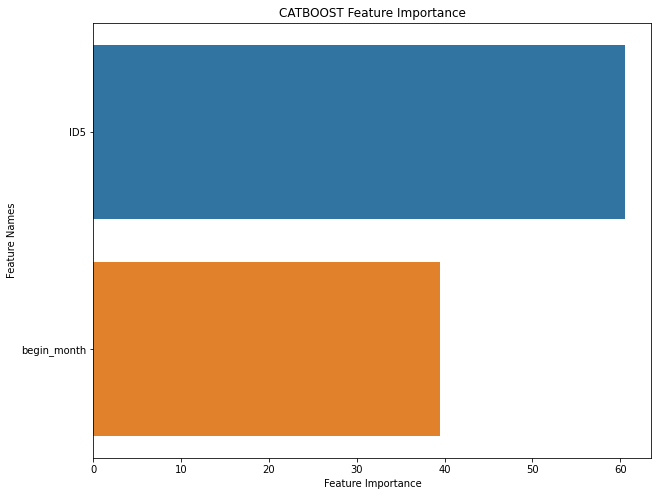

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 불러오기

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')

### submission 파일 저장

In [ ]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.086645,0.155864,0.757491
1,26458,0.307933,0.330448,0.361619
2,26459,0.038897,0.065683,0.895420
3,26460,0.048185,0.069440,0.882374
4,26461,0.054126,0.239215,0.706659
...,...,...,...,...
9995,36452,0.059636,0.235768,0.704597
9996,36453,0.349838,0.170755,0.479408
9997,36454,0.044607,0.130579,0.824814
9998,36455,0.127432,0.338161,0.534407


In [ ]:
sub.to_csv('submission0523_Final.csv', index=False)